In [2]:
import pandas as pd
import numpy as np
from haversine import haversine
import networkx as nx
import itertools
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import psycopg2

df = pd.read_csv('4h_timeFrame_not_at_3_fing_am.csv')

/home/theo/anaconda3/envs/gsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/theo/anaconda3/envs/gsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/theo/anaconda3/envs/gsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:

# properties.read(os.path.join('.','sql_server.ini'))
# properties = properties['SERVER']

# host    = properties['host']
# db_name = properties['db_name']
# uname   = properties['uname']
# pw      = properties['pw']
# port    = properties['port']

host    = '195.251.230.8'
db_name = 'doi105281zenodo1167595'
uname   = 'students'
pw      = 'infol@bdbl@bs2017'
port    = '46132'

# ts>1456802710 AND ts<1456975510 

# traj_sql = 'SELECT * FROM ais_data.dynamic_ships WHERE  mmsi=226179000'
traj_sql = 'SELECT * FROM ais_data.dynamic_ships WHERE  ts>1456702710 AND ts<1456975510 '
ports_sql = 'SELECT * FROM ports.ports_of_brittany'

con = psycopg2.connect(database=db_name, user=uname, password=pw, host=host, port = port)
# traj = gpd.GeoDataFrame.from_postgis(traj_sql, con, geom_col='geom' )
ports = gpd.GeoDataFrame.from_postgis(ports_sql, con, geom_col='geom' )

con.close()


ports.geom = ports.geom.apply(lambda x: x[0])

In [4]:
df.head()

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,velocity,datetime
0,1.884809e+07,227408710.0,0.0,0.0,0.000000,258.100000,511.000000,-4.490398,48.379186,1.456818e+09,POINT (-4.4903984 48.3791865),0.013741,2016-03-01 07:36:00
1,1.758572e+07,228853000.0,7.0,-127.0,6.169685,200.775984,511.000000,-3.891684,47.732670,1.456818e+09,POINT (-3.891684385826772 47.73266998031496),0.153449,2016-03-01 07:36:00
2,1.884808e+07,227686540.0,0.0,0.0,6.400000,199.300000,511.000000,-4.464395,48.327780,1.456818e+09,POINT (-4.464395 48.32778),6.911790,2016-03-01 07:36:00
3,1.751793e+07,226216000.0,7.0,0.0,0.000000,196.639167,302.466667,-4.175265,47.835712,1.456818e+09,POINT (-4.175265398333333 47.83571188333333),0.001396,2016-03-01 07:36:00
4,1.751790e+07,227270000.0,5.0,-127.0,0.000000,0.000000,511.000000,-4.478274,48.383153,1.456818e+09,POINT (-4.478274466666667 48.38315333333333),0.003177,2016-03-01 07:36:00


In [5]:
df.geom = df[['lon', 'lat']].apply(lambda x: Point(x[0],x[1]), axis=1)

In [6]:
df = gpd.GeoDataFrame(df, geometry='geom')

In [7]:
def in_radius(df, diam=1500):
    res = []
    for ind_i, ind_j, val_i, val_j in nparray_combinations(df):
        dist = haversine(val_i, val_j)*1000
        if (dist<diam):
            res.append((ind_i,ind_j))   
    return res
            

In [8]:
def connected_edges(data):
    G = nx.Graph()
    G.add_edges_from(data)
    return [sorted(list(cluster)) for cluster in nx.connected_components(G)]

In [9]:
def nparray_combinations(arr):
    for i in range(arr.shape[0]):
        for j in range(i+1, arr.shape[0]):
            yield i, j, arr[i,:], arr[j,:]

In [10]:
def eval_candidate(candidate, pairs):
    for pair in itertools.combinations(candidate,2):
        if pair not in pairs:
            return False
    return True

In [11]:
def circle_cluster(timeframe, min_cardinality = 2, diam=500):
    pairs = in_radius(timeframe[['lon', 'lat']].values, diam)
    full_sets = connected_edges(pairs)
    clusters = []
    for individual_sets in full_sets:
        # MAYBE FROM BIG TO SMALL INSTEAD OF SMALL TO BIG
        for j in range(min_cardinality,len(individual_sets)+1):
            for candidate in itertools.combinations(individual_sets,j):
                 if eval_candidate(candidate, pairs):
                        clusters.append(translate(candidate, timeframe))
#     print('----')
#     print(clusters)
#     print('----')
    return clusters

For each timeframe:
    get pairs of points with distance < diam
    model them as a graph and get all the connected edges
    for each group of edges:
        get all the combinations with lenght r (min_cardinality<r<len(group))[we need all possible combinations to ensure we find all possible groups]
        for each combination:
            get all combinations with length 2 (pairs)
            if all pairs are within distance <diam>, add it to the clusters
    if timeframe is 1st:
        add clusters to flocks with duration 1 and start_time=finish_time=timestamp
    else:
        for each cluster in clusters:
            if cluster is in previous flock instance add 1 to duration and change endtime
                if duration > min_samples:
                    if cluster in flocks change it with new instance
                    else add it to flocks
            else:
                add cluster to flocks with duration = 1 and start_time=finish_time=timestamp

In [12]:
def translate(candidates, sdf):
    return tuple([sdf.iloc[candidate].mmsi for candidate in candidates])

In [13]:
def ttt(history, present, flocks, ts, min_samples=3):
    fixed = []
    for cluster in present:
        try:
            index = [clst[0] for clst in history].index(cluster)
            flock = (cluster, history[index][1]+1, history[index][2], ts)
            fixed.append(flock)
            if flock[1] >= min_samples:
                try: 
                    flock_index = [clst[0] for clst in flocks].index(cluster)
                    flocks.pop(flock_index)
                except:
                    pass
                flocks.append(flock)
        except ValueError:
            fixed.append((cluster, 1,ts,ts))
    return fixed, flocks

In [27]:
min_samples = 3
min_cardinality = 2
diam = 2000

flocks = []
tdf = df.loc[df.velocity > 2]
for ind, (ts, sdf) in enumerate(tdf.groupby('datetime')):
    print (ind+1,' / ', df.datetime.nunique(), end='\r')
    if ind == 0:
        hist = circle_cluster(sdf, min_cardinality, diam)
        hist = [(val, 1,ts,ts) for val in hist]
        continue
    present = circle_cluster(sdf)
    hist, flocks = ttt(hist, present, flocks, ts, min_samples)

In [30]:
[print (i, val[1]) for i, val in enumerate(flocks)]

0 4
1 3
2 3
3 3
4 5
5 3
6 3
7 3
8 3
9 3
10 3
11 4
12 4
13 4
14 4
15 3
16 3
17 3
18 3
19 3
20 3
21 4
22 3
23 3
24 3
25 3
26 3
27 3
28 5
29 3
30 3
31 3
32 3
33 3
34 3
35 3
36 6
37 4
38 3
39 4
40 5
41 3
42 3
43 3
44 3
45 4
46 4
47 5
48 3
49 3
50 3
51 3
52 5
53 3
54 4
55 4
56 3
57 5
58 3
59 3
60 4
61 3
62 3
63 3
64 3
65 3
66 4
67 4
68 3
69 3
70 3
71 5
72 3
73 6
74 4
75 6
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 4
88 3
89 3
90 3
91 3
92 3
93 3
94 4
95 3
96 3
97 3
98 4
99 4
100 3
101 6
102 3
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 5
112 4
113 4
114 3
115 5
116 6
117 3
118 3
119 3
120 3
121 3
122 3
123 3
124 3
125 3
126 6
127 5
128 6
129 3
130 3
131 6
132 3
133 3
134 3
135 3
136 3
137 3
138 3
139 5
140 3
141 5
142 7
143 3
144 6
145 4
146 4
147 3
148 4
149 3
150 3
151 5
152 4
153 3
154 3
155 5
156 3
157 4
158 3
159 7
160 3
161 3
162 4
163 7
164 4
165 4
166 3
167 3
168 9
169 4
170 3
171 3
172 3
173 3
174 5
175 3
176 3
177 3
178 3
179 7
180 3
181 3
182 3
183 3
184 5


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [29]:
from datetime import datetime

df.datetime = df.datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

TypeError: strptime() argument 1 must be str, not Timestamp

In [41]:
def map_plot(df1, df2 = None, color=['r', 'g'], figsize = (15,15)):
    '''
    Plot one or two dataframes on top of eachother.

    TODO - Add support for N Dataframes and more parameters, other that figsize.
    '''
    df1.crs = {'init': 'epsg:4326'}
    ax = df1.to_crs(epsg=3857).plot(figsize=figsize,c=color[0], column='datetime')
    if df2 is not None:
        df2.crs = {'init': 'epsg:4326'}
        df2.to_crs(epsg=3857).plot(figsize=figsize,c=color[1], ax=ax)
    ctx.add_basemap(ax)

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
http://tile.stamen.com/terrain/18/127844/90789.png

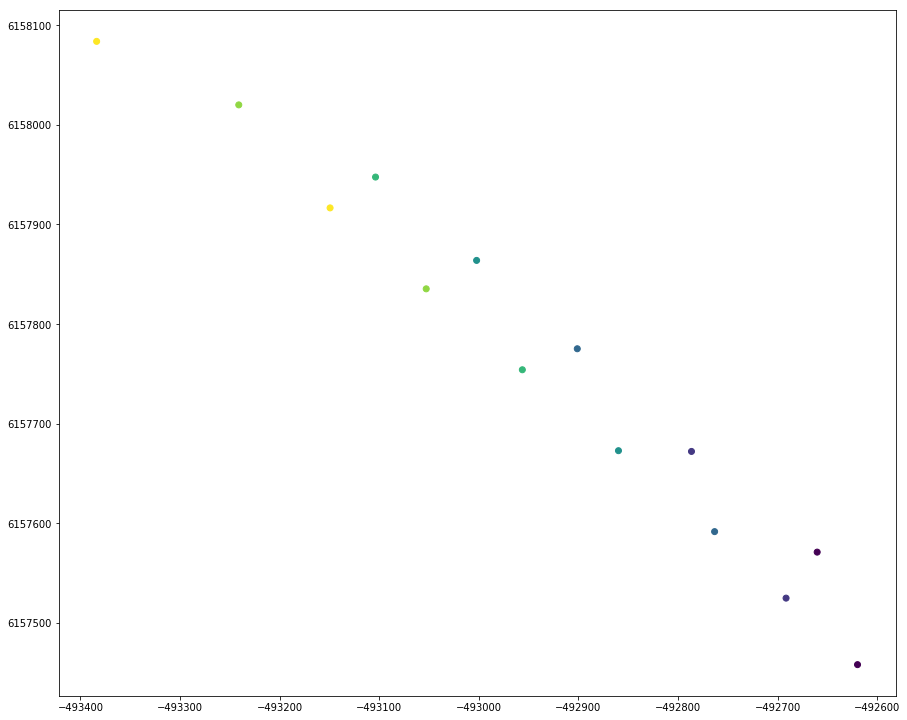

In [45]:
plot_flock(df, flocks, 179)

In [44]:
def plot_flock(df, flocks, i):
#     strt = datetime.strptime(flocks[i][2], '%Y-%m-%d %H:%M:%S')
#     stp = datetime.strptime(flocks[i][3], '%Y-%m-%d %H:%M:%S')
    tmp = df.loc[(df.mmsi.isin(flocks[i][0])) & (df.datetime>=flocks[i][2]) & (df.datetime<=flocks[i][3])]
    map_plot(tmp)

NameError: name 'flocks' is not defined

In [91]:
tmp[0]

(0, 7)

In [92]:
(array([0]), array([7])) in tmp

NameError: name 'array' is not defined

In [79]:
list(nparray_combinations(np.expand_dims(np.asarray(tst[0]), axis=1)))

0 1 [0] [7]
0 2 [0] [11]
0 3 [0] [18]
1 2 [7] [11]
1 3 [7] [18]
2 3 [11] [18]


[(0, 1, array([0]), array([7])),
 (0, 2, array([0]), array([11])),
 (0, 3, array([0]), array([18])),
 (1, 2, array([7]), array([11])),
 (1, 3, array([7]), array([18])),
 (2, 3, array([11]), array([18]))]

In [43]:
list(nparray_combinations(sdf))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (

In [169]:
import itertools
c = [1,2,3,4]
for i in itertools.combinations(c,2):
     print (*i)

1 2
1 3
1 4
2 3
2 4
3 4


In [135]:
lst = [1,2,3]

In [139]:
for point in lst:
    for j in [val for val in lst if val !=point]:
        print(point, j)

1 2
1 3
2 1
2 3
3 1
3 2


In [143]:
tuple(sorted((3,1)))

(1, 3)

In [45]:
lst = [1,2,3]

In [46]:
lst.index(3)

2